In [5]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from glob import glob
from tips.io import load_ds

tunit = 1/100.
eunit = 1.0
natom = 640

def plot_energies(ax, ds, init, color):
    e_avg = np.array([d['energy'] for d in ds])/640
    t = np.arange(len(e_avg))*tunit
    l2, = ax.plot(t, e_avg, color=color, lw=1, alpha=0.2)
    
    try:
        e_bias = np.array([d['energy_bias'] for d in ds])/640
        e_std = np.array([d['energy_std'] for d in ds])/640
        l1 = ax.fill_between(t, e_avg-e_std, e_avg+e_std, color=color, alpha=0.5)
        return (l1,l2)
        return l2
    except:
        return l2

def doplots(stride=1):
    l1, l2 = None, None
    for ftraj in glob(f'../{name}/emd/gen{gen}/*/asemd.traj'):
        init = Path(ftraj).parent.name
        traj = load_ds(ftraj, fmt='asetraj', index=f'::{stride}')
        l1 = plot_energies(ax1, traj, init, 'tab:green')
        try:
            idx = np.loadtxt(f'../{name}/merge/gen{gen}/{init}/merged.idx')//stride
            sort = np.argsort(idx)
            e_model = np.array([traj[int(i)]['energy'] for i in idx]) / natom
            f_model = np.array([traj[int(i)]['force'] for i in idx])
            # f_std = np.array([traj[int(i)]['force_std'] for i in idx])
            # e_std = np.array([traj[int(i)]['energy_std'] for i in idx])
            
            label = load_ds(f'../{name}/merge/gen{gen}/{init}/merged.traj', fmt='asetraj')
            e_label = np.array([l['energy'] for l in label]) * eunit / natom
            f_label = np.array([l['force'] for l in label]) * eunit
            print(f"{name}/gen{gen}/{init:14s}",
                  f"e_rmse: {np.sqrt(np.mean((e_model-e_label)**2))*1000:5.2f} meV/a, ",
                  f"f_rmse: {np.sqrt(np.mean((f_model-f_label)**2))*1000:5.2f} meV/Å, ",
                  f"e_maxerr: {np.max(np.abs(e_model-e_label)):5.3f}, ",
                  f"f_maxerr: {np.max(np.abs(f_model-f_label)):5.3f}",
                 #  f"e_max: {np.max(np.abs(e_label)):6.3f}, ",
                 #  f"f_max: {np.max(np.abs(f_label)):6.3f}",
                 )
            #print(idx)
            #print(f"{np.sum(np.max(np.abs(f_label),axis=(1,2))>30)}",np.max(np.abs(f_label-f_model),axis=(1,2)))
            #print(f"{np.sum(e_label>-125.1)}")
            l2, = ax1.plot(idx[sort]*tunit, e_label[sort], '--x', ms=2, lw=1, color='tab:red')
            ax2.scatter(e_model, e_label, color='tab:red', s=5,ec=None)
            emin, emax = -125.23, -125.17
            ax2.plot([emin, emax], [emin, emax], ':', lw=1, color='gray')
            ax1.set_ylim(emin, emax)
            ax2.set_ylim(emin, emax)
            ax2.set_xlim(emin, emax)
            fmin, fmax = -10,10
            ax3.scatter(f_model, f_label, color='tab:red', s=2, alpha=0.5,ec=None)
            ax3.plot([fmin, fmax], [fmin, fmax], ':', lw=1, color='gray')
            ax3.set_xlim(fmin, fmax)
            ax3.set_ylim(fmin, fmax)
            # ax3.set_xticks(np.arange(-10,11,5))
            # ax3.set_yticks(np.arange(-10,11,5))
        except:
            pass
    
    ax1.set_xlabel('time [ps]')
    ax1.set_title(title, fontsize=10)
    ax2.set_xlabel('$E_{pred}~[eV/atom]$')
    ax3.set_xlabel('$F_{pred}~[eV/\AA]$')
    return l1, l2
    


exp/adam1-sin-run1/gen30/m0i32-r1.16    e_rmse:  8.31 meV/a,  f_rmse: 350.29 meV/Å,  e_maxerr: 0.010,  f_maxerr: 15.197
exp/adam1-sin-run1/gen30/m16i16-r1.08   e_rmse:  0.81 meV/a,  f_rmse: 100.13 meV/Å,  e_maxerr: 0.002,  f_maxerr: 0.778
exp/adam1-sin-run1/gen30/m32i0-r1.16    e_rmse:  0.71 meV/a,  f_rmse: 102.44 meV/Å,  e_maxerr: 0.001,  f_maxerr: 0.851
exp/adam1-sin-run1/gen30/m16i16-r1.16   e_rmse:  1.22 meV/a,  f_rmse: 105.76 meV/Å,  e_maxerr: 0.002,  f_maxerr: 0.933
exp/adam1-sin-run1/gen30/m0i32-r1.08    e_rmse:  0.87 meV/a,  f_rmse: 96.71 meV/Å,  e_maxerr: 0.001,  f_maxerr: 0.753
exp/adam1-sin-run1/gen30/m32i0-r1.08    e_rmse:  0.84 meV/a,  f_rmse: 100.30 meV/Å,  e_maxerr: 0.001,  f_maxerr: 0.711


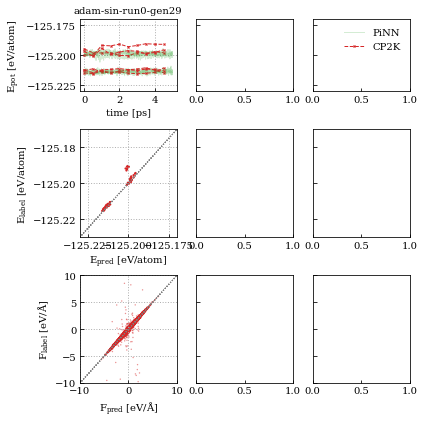

In [6]:
f, axs = plt.subplots(3,3, figsize=[6,6], sharey='row', gridspec_kw={'height_ratios': [2,3,3]})
for (name, gen, title), (ax1, ax2, ax3) in zip([
   ['exp/adam1-sin-run1',30, 'adam-sin-run0-gen29'],
   #['exp/adam1-sin-run1',22, 'adam-sin-run0-gen29'],
   #['exp/adam1-sin-run3',19, 'adam-sin-run1-gen20'],
   # ['exp/adam1-sin-quench',14, 'adam-sin-run1-gen20'],
   #['exp/adam1-sin-npt0',19, 'adam-sin-run2-gen20']
], axs.T):
    l1, l2 = doplots(stride=200)
    ax1.grid(lw=1, ls=':', which='both')
    ax2.grid(lw=1, ls=':', which='both')
    ax3.grid(lw=1, ls=':', which='both')
    
axs[0,-1].legend([l1,l2], ['PiNN', 'CP2K'],facecolor='w',frameon=True,edgecolor='none')
axs[0,0].set_ylabel('$E_{pot}~[eV/atom]$')
axs[1,0].set_ylabel('$E_{label}~[eV/atom]$')
axs[2,0].set_ylabel('$F_{label}~[eV/\AA]$')
plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.4)
# plt.savefig('al-hyper-ckpt.png')

In [9]:
from tips.io import load_ds
from ase.io import write

traj = load_ds('../exp/adam1-sin-run1/emd/gen30/m0i32-r1.16/asemd.traj',fmt='asetraj', index='::200')
traj_ase = traj.convert(fmt='ase')

for idx, atoms in enumerate(traj_ase):
    if 'stress' in atoms.calc.results : del atoms.calc.results['stress']    
    if  idx%100==0:
        print(f'\r{idx}', end='')
        smart_wrap(atoms)
    else:
        unwrap(traj_ase[idx-1], traj_ase[idx])
write('tmp.xyz', traj_ase)

500

In [626]:
from tips.io import load_ds
from ase.io import write

traj = load_ds('../exp/adam1-sin-run1/merge/gen28/m16i16-r1.16/merged.traj',fmt='asetraj', index=':')
traj_ase = traj.convert(fmt='ase')
for idx, atoms in enumerate(traj_ase):
    if 'stress' in atoms.calc.results : del atoms.calc.results['stress']    
    if  True:
        print(f'\r{idx}', end='')
        smart_wrap(atoms)
    else:
        unwrap(traj_ase[idx-1], traj_ase[idx])
write('tmp.xyz', traj_ase)

9

In [8]:
def smart_wrap(atoms):
      #!/usr/bin/env python
    import numpy as np
    from ase import Atoms, neighborlist
    from ase.io import write
    from scipy import sparse
    natoms =  len(atoms)
    
    assert (atoms.cell.angles() == 90.).all(), "Only orthogonal cells allowed."
    cell = atoms.cell.diagonal()
    atoms.wrap()
  
    cutoff = {
        ("H", "C"): 1.74,
        ("H", "N"): 1.9,
        ("H", "O"): 1.9,
        ("C", "C"): 2,
        ("C", "N"): 2,
        ("C", "O"): 2,
    }

    nl_i, nl_j, nl_d = neighborlist.neighbor_list("ijd", atoms, cutoff, self_interaction=False)
    conMat = sparse.dok_matrix((natoms, natoms), dtype=np.int8)
    conMat[nl_i, nl_j] = 1  # we have several running indices here prefixed by (nl, mol, h)
    conMat[nl_j, nl_i] = 1  # v---- shamelessly taken from the ase documentation
    n_mol, mol_assign = sparse.csgraph.connected_components(conMat)
    
    for mol_i in range(n_mol):
        pos_mol = atoms.positions[mol_assign==mol_i]
        mass_mol = atoms.get_masses()[mol_assign==mol_i]
        pos_mol -= np.rint((pos_mol-pos_mol[:1,:])/cell[None,:])*cell[None,:]
        com_mol = mass_mol@pos_mol/(mass_mol.sum())
        pos_mol -= np.rint(com_mol/cell[None,:]-0.5)*cell[None,:]
        atoms.positions[mol_assign==mol_i] = pos_mol
        
def unwrap(atoms_prev, atoms_next):
    cell = atoms_next.cell.diagonal()
    atoms_next.positions -= np.rint((atoms_next.positions-atoms_prev.positions)
                                    /cell[None,:])*cell[None,:]    

40ps-EKF@300K
--------------------
40ps-Adam@300K
--------------------
ALGen3-Adam@340K
--------------------


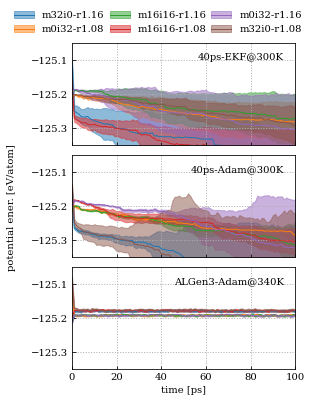

In [82]:
f, axs = plt.subplots(3,1, figsize=[4,6], sharex=True, sharey=True)
handles, labels = [], []
stride = 100
for tag, match, ax in zip(['40ps-EKF@300K', '40ps-Adam@300K', 'ALGen3-Adam@340K'],
                          ['nvt-300k-100ps/pils-v6-pinet-ekf-*',
                           'nvt-300k-100ps/pils-v6-pinet-adam-*',
                           'al-adam/nvt-340k-100ps/*'],
                          axs):
    print(tag)
    ax.text(0.95, 0.9, tag, transform=ax.transAxes, ha='right', va='top')
    for fname in glob(f'../trajs/ase/{match}/asemd.traj'):
        init = '-'.join(Path(fname).parent.name.split('-')[-2:])
        ds = load_ds(fname,fmt='asetraj', index=f'::{stride}')
        e_avg = np.array([datum['energy_avg'] for datum in ds])/natom
        e_std = np.array([datum['energy_std'] for datum in ds])/natom
        t = np.arange(len(e_avg))*0.01*stride
        l1, = ax.plot(t, e_avg, lw=1)
        l2 = ax.fill_between(t, e_avg-e_std, e_avg+e_std, color=l1.get_color(), alpha=0.5)
        handles.append((l1,l2))
        labels.append(init)
        
        if ax==axs[0]:
            ax.legend(handles, labels, ncol=3, loc=3, bbox_to_anchor=[-0.3,1], columnspacing=0.5)
        elif ax==axs[-1]:
            ax.set_xlabel('time [ps]')
        ax.set_ylim(-125.35, -125.05)
        ax.set_xlim(0,100)
        ax.grid(b=True,lw=1, ls=':')
    print("-"*20)
f.text(-0.1, 0.5, 'potential ener. [eV/atom]', va='center',rotation='vertical')
f.subplots_adjust(wspace=0.1, hspace=0.1)
# plt.savefig('pils-v6-models.pdf')

In [83]:
traj = load_ds('../trajs/ase/al-adam/nvt-340k-100ps/m32i0-r1.16/asemd.traj',fmt='asetraj', index='::100')
traj.convert('tmp.xyz', fmt='extxyz')